In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile, assemble, execute
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.providers.aer.noise import pauli_error
from numpy.random import randint
import numpy as np
import random
import hashlib

In [2]:
def visualizar_secuencia(secuencia, bits, bases, k=1):
    """
    Visualiza los primeros k circuitos cuánticos del criptograma,
    mostrando el bit y la base utilizados para codificar cada uno.
    k (int): Número de circuitos a visualizar (por defecto 1).
    """
    for i in range(min(k, len(secuencia))):
        bit = bits[i]
        base = bases[i]
        base_str = "(computacional)" if base == 0 else "(diagonal)"
        print(f"Qubit {i} | Bit: {bit} | Base: {base_str}")
        display(secuencia[i].draw('mpl', style="iqp"))

In [3]:
def canalcuantico(circuit: QuantumCircuit) -> QuantumCircuit:
    
    #Parte libre de errores en los canales que vamos a transmitir del 0 al 7
    sin_error = pauli_error([('X', 0), ('I', 1)])
    for i in range(7):
        circuit.append(sin_error,[i])
    
    return circuit

In [4]:
def introduce_error(secuencia: list, error_prob=1.0) -> list:
    """
    Introduce errores aleatorios X, Y o Z directamente en los circuitos de la lista dada.

    Parámetros:
        secuencia (list): Lista de circuitos cuánticos ya construidos.
        error_prob (float): Probabilidad de que se introduzca un error en cada circuito (0 a 1).

    Retorna:
        list: La misma lista, con errores introducidos directamente en los circuitos.
    """
    import random

    for circuito in secuencia:
        if random.random() < error_prob:
            qubit_error = random.randint(0, 6)
            tipo_error = random.choice(['X', 'Y', 'Z'])
            circuito.barrier()
            if tipo_error == 'X':
                circuito.x(qubit_error)
            elif tipo_error == 'Y':
                circuito.y(qubit_error)
            elif tipo_error == 'Z':
                circuito.z(qubit_error)
            circuito.barrier()

    return secuencia

In [5]:
def steane_encode(input_state: QuantumCircuit = None) -> QuantumCircuit:
    """Crea el circuito de codificación de Steane."""
    qr = QuantumRegister(7, 'q')  # 7 qubits de información
    circ = QuantumCircuit(qr)

    # Si se proporciona un estado cuántico, lo insertamos en el qubit 0
    if input_state:
        # Aplicamos el estado al qubit 0 usando circ.compose
        circ.compose(input_state, qubits=[0], inplace=True)

    circ.barrier()
    # Codificación de Steane
    circ.h(4)
    circ.h(5)
    circ.h(6)
    circ.cx(0, 1)
    circ.cx(0, 2)
    circ.barrier()
    
    circ.cx(6, 0)
    circ.cx(6, 1)
    circ.cx(6, 3)
    circ.barrier()
    
    circ.cx(5, 0)
    circ.cx(5, 2)
    circ.cx(5, 3)
    circ.barrier()
    
    circ.cx(4, 1)
    circ.cx(4, 2)
    circ.cx(4, 3)   
    circ.barrier()
    
    return circ

In [6]:
#funcion para codificar la secuencia en arreglo a las bases elegidas
def codificacion(bits, bases):
    secuencia = []
    for i in range(n):
        resultado_cr = ClassicalRegister(1, 'bit_leido')
        qc = QuantumCircuit(1,0)
        qc.add_register(resultado_cr)
        qc.reset(0)
        
        if bases[i] == 0: # Trasmitimos el cubit en la base computacional
            if bits[i] == 0:
                # Codificamos |0> bit=0, base=0
                pass
            else:
                # Codificamos |1> bit=1, base=0
                qc.x(0)
        else: # Transmitimos el cubit en la base diagonal segun protocolo BB84
            if bits[i] == 0:
                # Transmitimos |+>  bit=0, base=1
                qc.h(0)
            else: 
                # Transmitimos |->  bit=1, base=1
                qc.x(0)
                qc.h(0)

        # Aplicamos la codificacion de Steane antes de transmitirlo
        qubit_encoded = steane_encode(qc)
        
        # Añadimos el cubit codificado a la secuencia a transmitir
        secuencia.append(qubit_encoded)
        
    return secuencia

In [7]:
def steane_sindrome(circ: QuantumCircuit) -> QuantumCircuit:
    """Añade medición del síndrome al circuito y realiza corrección."""

    """
    # Verificamos si el ClassicalRegister ya existe y si no lo creamos
    if 'bit_leido' not in [cr.name for cr in circ.cregs]:
        #resultado_cr = ClassicalRegister(1, 'bit_leido')
        #circ.add_register(resultado_cr)
    else:
        # Usa el registro existente
        resultado_cr = [cr for cr in circ.cregs if cr.name == 'bit_leido'][0]
    """
    # Verificar si los registros ancilla ya existen
    if not any(qr.name == 'anc' for qr in circ.qregs):
        ancilla_qr = QuantumRegister(6, 'anc')
        circ.add_register(ancilla_qr)
    else:
        ancilla_qr = [qr for qr in circ.qregs if qr.name == 'anc'][0]

    if not any(cr.name == 'ancilla_bit' for cr in circ.cregs):
        ancilla_cr = ClassicalRegister(6, 'ancilla_bit')
        circ.add_register(ancilla_cr)
    else:
        ancilla_cr = [cr for cr in circ.cregs if cr.name == 'ancilla_bit'][0]


    # Preparación de ancillas
    circ.barrier()
    for i in range(6):
        circ.reset(ancilla_qr[i])
        circ.h(ancilla_qr[i])

    # Medición en Z
    circ.cz(ancilla_qr[0], 0)
    circ.cz(ancilla_qr[0], 2)
    circ.cz(ancilla_qr[0], 4)
    circ.cz(ancilla_qr[0], 6)
    circ.barrier()

    circ.cz(ancilla_qr[1], 1)
    circ.cz(ancilla_qr[1], 2)
    circ.cz(ancilla_qr[1], 5)
    circ.cz(ancilla_qr[1], 6)
    circ.barrier()

    circ.cz(ancilla_qr[2], 3)
    circ.cz(ancilla_qr[2], 4)
    circ.cz(ancilla_qr[2], 5)
    circ.cz(ancilla_qr[2], 6)
    circ.barrier()

    # Medición en X
    circ.cx(ancilla_qr[3], 0)
    circ.cx(ancilla_qr[3], 2)
    circ.cx(ancilla_qr[3], 4)
    circ.cx(ancilla_qr[3], 6)
    circ.barrier()

    circ.cx(ancilla_qr[4], 1)
    circ.cx(ancilla_qr[4], 2)
    circ.cx(ancilla_qr[4], 5)
    circ.cx(ancilla_qr[4], 6)
    circ.barrier()

    circ.cx(ancilla_qr[5], 3)
    circ.cx(ancilla_qr[5], 4)
    circ.cx(ancilla_qr[5], 5)
    circ.cx(ancilla_qr[5], 6)
    circ.barrier()

    for i in range(6):
        circ.h(ancilla_qr[i])

    circ.measure(ancilla_qr, ancilla_cr)
    circ.barrier()

    # Corrección condicional según síndrome
    known_syndromes = {
        0b000001: ('X', 0), 0b000010: ('X', 1), 0b000011: ('X', 2),
        0b000100: ('X', 3), 0b000101: ('X', 4), 0b000110: ('X', 5), 0b000111: ('X', 6),
        0b001000: ('Z', 0), 0b010000: ('Z', 1), 0b011000: ('Z', 2),
        0b100000: ('Z', 3), 0b101000: ('Z', 4), 0b110000: ('Z', 5), 0b111000: ('Z', 6),
        0b001001: ('Y', 0), 0b010010: ('Y', 1), 0b011011: ('Y', 2),
        0b100100: ('Y', 3), 0b101101: ('Y', 4), 0b110110: ('Y', 5), 0b111111: ('Y', 6)
    }

    for syndrome, (err_type, qubit) in known_syndromes.items():
        with circ.if_test((ancilla_cr, syndrome)):
            if err_type == 'X':
                circ.x(qubit)
            elif err_type == 'Z':
                circ.z(qubit)
            elif err_type == 'Y':
                circ.y(qubit)

    circ.barrier()
    return circ


In [8]:
def steane_decode(circ: QuantumCircuit) -> QuantumCircuit:
    """Decodificación de Steane."""
    circ.cx(4, 1)
    circ.cx(4, 2)
    circ.cx(4, 3)
    circ.barrier()

    circ.cx(5, 0)
    circ.cx(5, 2)
    circ.cx(5, 3)
    circ.barrier()

    circ.cx(6, 0)
    circ.cx(6, 1)
    circ.cx(6, 3)
    circ.barrier()

    circ.cx(0, 1)
    circ.cx(0, 2)
    circ.h(4)
    circ.h(5)
    circ.h(6)
    circ.barrier()

    return circ


In [9]:
def medicion(transmision, bases):
    backend = Aer.get_backend('aer_simulator')
    secuencia_leida = []

    for i, circ in enumerate(transmision):

        # Verificamos si el ClassicalRegister ya existe y si no lo creamos
        """
        if 'bit_leido' not in [cr.name for cr in circ.cregs]:
            resultado_cr = ClassicalRegister(1, 'bit_leido')
            circ.add_register(resultado_cr)
        else:
            # Usa el registro existente
            resultado_cr = [cr for cr in circ.cregs if cr.name == 'bit_leido'][0]
        """
        # Calculamos el Síndrome y lo corregimos
        circ = steane_sindrome(circ)

        # Decodificación según Steane
        steane_decode(circ)

        # Aplicar rotación si base diagonal en cubit 0 según protocolo BB84
        if bases[i] == 1:
            circ.h(0)

        # Medir qubit 0 en bit clásico 0
        resultado_cr = [cr for cr in circ.cregs if cr.name == 'bit_leido'][0]
        circ.measure(0, resultado_cr[0])

        # Revertir la rotación si se aplicó en la medición
        if bases[i] == 1:
            circ.h(0)

        # Ejecutar el circuito en el backend y obtener los resultados
        result = execute(circ, backend, shots=1, memory=True).result()
        memoria = result.get_memory()[0].replace(" ", "")

        # Obtener solo el bit correspondiente al qubit 0 (último bit clásico añadido)
        bit = int(memoria[-1])
        secuencia_leida.append(bit)

        # Mostrar solo el síndrome (los 6 bits más a la izquierda)
        print(f"Síndrome ejecución {i + 1}: {memoria[:6]} | Lectura: {bit}")

    return secuencia_leida


In [10]:
def eve_encode(secuencia: list) -> list:
    """Eve para evitar no ser detectada puede INTENTAR volver a codificar la transmision de los primeros 7 qubits segun Steane."""

    for circ in secuencia:
       # Codificación de Steane
        circ.barrier() 
        circ.h(4)
        circ.h(5)
        circ.h(6)
        circ.cx(0, 1)
        circ.cx(0, 2)
        circ.barrier()
    
        circ.cx(6, 0)
        circ.cx(6, 1)
        circ.cx(6, 3)
        circ.barrier()
    
        circ.cx(5, 0)
        circ.cx(5, 2)
        circ.cx(5, 3)
        circ.barrier()
    
        circ.cx(4, 1)
        circ.cx(4, 2)
        circ.cx(4, 3)   
        circ.barrier() 

    return secuencia
    

In [11]:
def obtener_indices_bases_comunes(alice_bases, bob_bases):
    """
    Devuelve los índices donde las bases de Alice y Bob coinciden.
    """
    return [i for i in range(len(alice_bases)) if alice_bases[i] == bob_bases[i]]

In [12]:
def extraer_claves_crudas(alice_bits, bob_bits, indices_comunes):
    """
    Genera las claves crudas de Alice y Bob con los bits donde usaron la misma base.
    """
    clave_alice = [alice_bits[i] for i in indices_comunes]
    clave_bob = [bob_bits[i] for i in indices_comunes]
    return clave_alice, clave_bob

In [13]:
def verificar_presencia_eve(clave_alice, clave_bob, porcentaje_muestra=0.2):
    """
    Realiza un muestreo aleatorio para detectar errores en la clave compartida.
    Devuelve claves finales (sin muestreo), número de errores y porcentaje de error.
    """
    longitud = len(clave_alice)
    n_muestra = max(1, int(porcentaje_muestra * longitud))
    indices_muestra = random.sample(range(longitud), n_muestra)

    errores = sum(clave_alice[i] != clave_bob[i] for i in indices_muestra)

    # Eliminar bits muestreados para clave final
    clave_final_alice = [bit for i, bit in enumerate(clave_alice) if i not in indices_muestra]
    clave_final_bob = [bit for i, bit in enumerate(clave_bob) if i not in indices_muestra]

    porcentaje_error = errores / n_muestra if n_muestra > 0 else 0

    return clave_final_alice, clave_final_bob, errores, porcentaje_error

In [14]:
def generar_clave_segura(clave_bits, longitud_deseada=1024):
    """
    Aplica hashing iterativo sobre la clave para generar una clave simétrica de longitud deseada.
    """
    clave_bin = ''.join(str(bit) for bit in clave_bits)
    clave_final = b''
    
    while len(clave_final) * 8 < longitud_deseada:
        hash_obj = hashlib.sha256(clave_bin.encode())
        clave_final += hash_obj.digest()
        clave_bin = hash_obj.hexdigest()  # Nuevo input para el siguiente hash

    return clave_final[:longitud_deseada // 8]  # Retorna en bytes

In [15]:
# ESTABLECEMOS LAS VARIABLES EN EL ENTORNO DE SIMULACION
np.random.seed(seed=200)
n = 100


In [16]:
# FASE 1 : ALICE GENERA LA SECUENCIA DE CUBITS CODIFICADOS SEGUN STEANE Y LES APLICA SU BASE DE TRANSMISION SEGUN PROTOCOLO BB84

# Genera una secuencia aleatoria de bits que servirá para generar la clave
Alice_bits = randint(2, size=n)
# Genera una secuencia aleatoria de bits para la transmisión en la Base Computacional o Diagonal
Alice_bases = randint(2, size=n)

# Generamos una secuencia que serán los cubits codificados aplicando Steane
secuencia_alice = codificacion(Alice_bits, Alice_bases)

#################################################################################
# Opcionalmente podemos visializar la secuencia de cubits codificados
#visualizar_secuencia(secuencia_alice, Alice_bits, Alice_bases, k=15)

In [17]:
# FASE 2 : ALICE TRANSMITE LA SECUENCIA DE CUBITS POR EL CANAL CUÁNTICO, PUEDE EXISTIR ESPIA O NO

transmision = []

# Transmisión libre de errores
for i in range(len(secuencia_alice)):
    transmision.append(canalcuantico(secuencia_alice[i]))

#Opcionalmente pueden existir errores en el canal
################################################
transmision = introduce_error(transmision, error_prob=1)

#Medicion del espia Eve
##############################################
#Eve_bases = randint(2, size=n)
#Eve_bits = medicion(transmision, Eve_bases)
#Adicionalmente Eve puede intentar volver a codificar según Steane
#transmision=eve_encode(transmision)
#Opcionalmente pueden existir errores en el canal
################################################
transmision = introduce_error(transmision, error_prob=0.5)


#################################################################################
# Opcionalmente podemos visializar la secuencia de cubits transmitidos
#visualizar_secuencia(transmision, Alice_bits, Alice_bases, k=5)



In [18]:
# FASE 3 : BOB RECIBE LA SECUENCIA DE CUBITS, APLICA LA CORRECCIÓN DE ERRORES SEGÚN STEANE Y LOS LEE, EN UNA BASE ALEATORIA SEGÚN PROTOCOLO BB84
# Genera una secuencia aleatoria de bits para la lectura en la Base Computacional o Diagonal
Bob_bases = randint(2, size=n)
Bob_bits = medicion(transmision, Bob_bases)

Síndrome ejecución 1: 001100 | Lectura: 1
Síndrome ejecución 2: 010000 | Lectura: 0
Síndrome ejecución 3: 110001 | Lectura: 0
Síndrome ejecución 4: 100100 | Lectura: 0
Síndrome ejecución 5: 111111 | Lectura: 1
Síndrome ejecución 6: 000100 | Lectura: 0
Síndrome ejecución 7: 111000 | Lectura: 0
Síndrome ejecución 8: 010001 | Lectura: 1
Síndrome ejecución 9: 000011 | Lectura: 1
Síndrome ejecución 10: 001001 | Lectura: 0
Síndrome ejecución 11: 110110 | Lectura: 1
Síndrome ejecución 12: 000110 | Lectura: 1
Síndrome ejecución 13: 011011 | Lectura: 1
Síndrome ejecución 14: 010110 | Lectura: 0
Síndrome ejecución 15: 000110 | Lectura: 0
Síndrome ejecución 16: 000111 | Lectura: 1
Síndrome ejecución 17: 110110 | Lectura: 0
Síndrome ejecución 18: 011011 | Lectura: 1
Síndrome ejecución 19: 000101 | Lectura: 0
Síndrome ejecución 20: 010110 | Lectura: 1
Síndrome ejecución 21: 110110 | Lectura: 0
Síndrome ejecución 22: 011110 | Lectura: 0
Síndrome ejecución 23: 011111 | Lectura: 0
Síndrome ejecución 2

In [19]:
#FASE 4: Ponemos en comun las bases de medición y extraemos la clave en bruto

indices_comunes = obtener_indices_bases_comunes(Alice_bases, Bob_bases)
clave_cruda_alice, clave_cruda_bob = extraer_claves_crudas(Alice_bits, Bob_bits, indices_comunes)


In [20]:
#FASE 5: Evaluación de la tasa de error y verificación de la existencia de un espía Eve 

clave_final_alice, clave_final_bob, errores, p_error = verificar_presencia_eve(clave_cruda_alice, clave_cruda_bob)

eve_presente = 'Eve_bases' in globals() and 'Eve_bits' in globals()

print("Pos | BaseA | BitA | BaseE | BitE | BaseB | BitB | Coincide (A=B) | Eve altera?")
print("-------------------------------------------------------------------------------")
for i in range(n):
    base_a = Alice_bases[i]
    bit_a = Alice_bits[i]
    base_b = Bob_bases[i]
    bit_b = Bob_bits[i]

    if eve_presente:
        base_e = Eve_bases[i]
        bit_e = Eve_bits[i]

        coincide_ab = base_a == base_b
        coincide_bits_ab = bit_a == bit_b
        coincide_ae = base_a == base_e

        resultado_ab = "✔" if coincide_ab and coincide_bits_ab else ("❌" if coincide_ab else "-")
        eve_altera = "⚠️" if not coincide_ae and coincide_ab else "-"
    else:
        base_e = "-"
        bit_e = "-"
        coincide_ab = base_a == base_b
        coincide_bits_ab = bit_a == bit_b
        resultado_ab = "✔" if coincide_ab and coincide_bits_ab else ("❌" if coincide_ab else "-")
        eve_altera = "-"

    print(f"{i:3} |   {base_a}    |   {bit_a}  |   {base_e}    |   {bit_e}  |   {base_b}    |   {bit_b}  |       {resultado_ab}     |     {eve_altera}")





print(f"Errores detectados: {errores} / {int(0.2 * len(clave_cruda_alice))}")
print(f"Porcentaje de error estimado: {p_error * 100:.2f}%")

if errores > 0:
    print("⚠️ Intervención de Eve detectada. Imposible generar clave simétrica")
else:
    print("✅ Comunicación segura, sin evidencia de espionaje.")
    print("\nClave final de Alice, los primeros 32 bits:")
    print(''.join(str(bit) for bit in clave_final_alice[:32]))

    print("\nClave final de Bob, los primeros 32 bits:")
    print(''.join(str(bit) for bit in clave_final_bob[:32]))

Pos | BaseA | BitA | BaseE | BitE | BaseB | BitB | Coincide (A=B) | Eve altera?
-------------------------------------------------------------------------------
  0 |   1    |   0  |   -    |   -  |   1    |   1  |       ❌     |     -
  1 |   1    |   1  |   -    |   -  |   0    |   0  |       -     |     -
  2 |   0    |   0  |   -    |   -  |   1    |   0  |       -     |     -
  3 |   0    |   0  |   -    |   -  |   0    |   0  |       ✔     |     -
  4 |   1    |   0  |   -    |   -  |   0    |   1  |       -     |     -
  5 |   0    |   1  |   -    |   -  |   1    |   0  |       -     |     -
  6 |   0    |   0  |   -    |   -  |   1    |   0  |       -     |     -
  7 |   1    |   1  |   -    |   -  |   0    |   1  |       -     |     -
  8 |   1    |   1  |   -    |   -  |   1    |   1  |       ✔     |     -
  9 |   0    |   0  |   -    |   -  |   0    |   0  |       ✔     |     -
 10 |   0    |   1  |   -    |   -  |   0    |   1  |       ✔     |     -
 11 |   1    |   1  |   - 

In [21]:
#FASE 5 Ampliación de la privacidad 
#Usando tecnicas tradicionales de Hashing, si no hemos detectado error realizamos una ampliación de la privacidad.

if errores > 0:
    print("Intervención de Eve detectada. Imposible generar clave simétrica")
else:
    clave_simetrica = generar_clave_segura(clave_final_alice, longitud_deseada=1024)
    print("Clave simétrica de 1024 bits generada:")
    print(clave_simetrica.hex())


Intervención de Eve detectada. Imposible generar clave simétrica


Qubit 0 | Bit: 0 | Base: (diagonal)


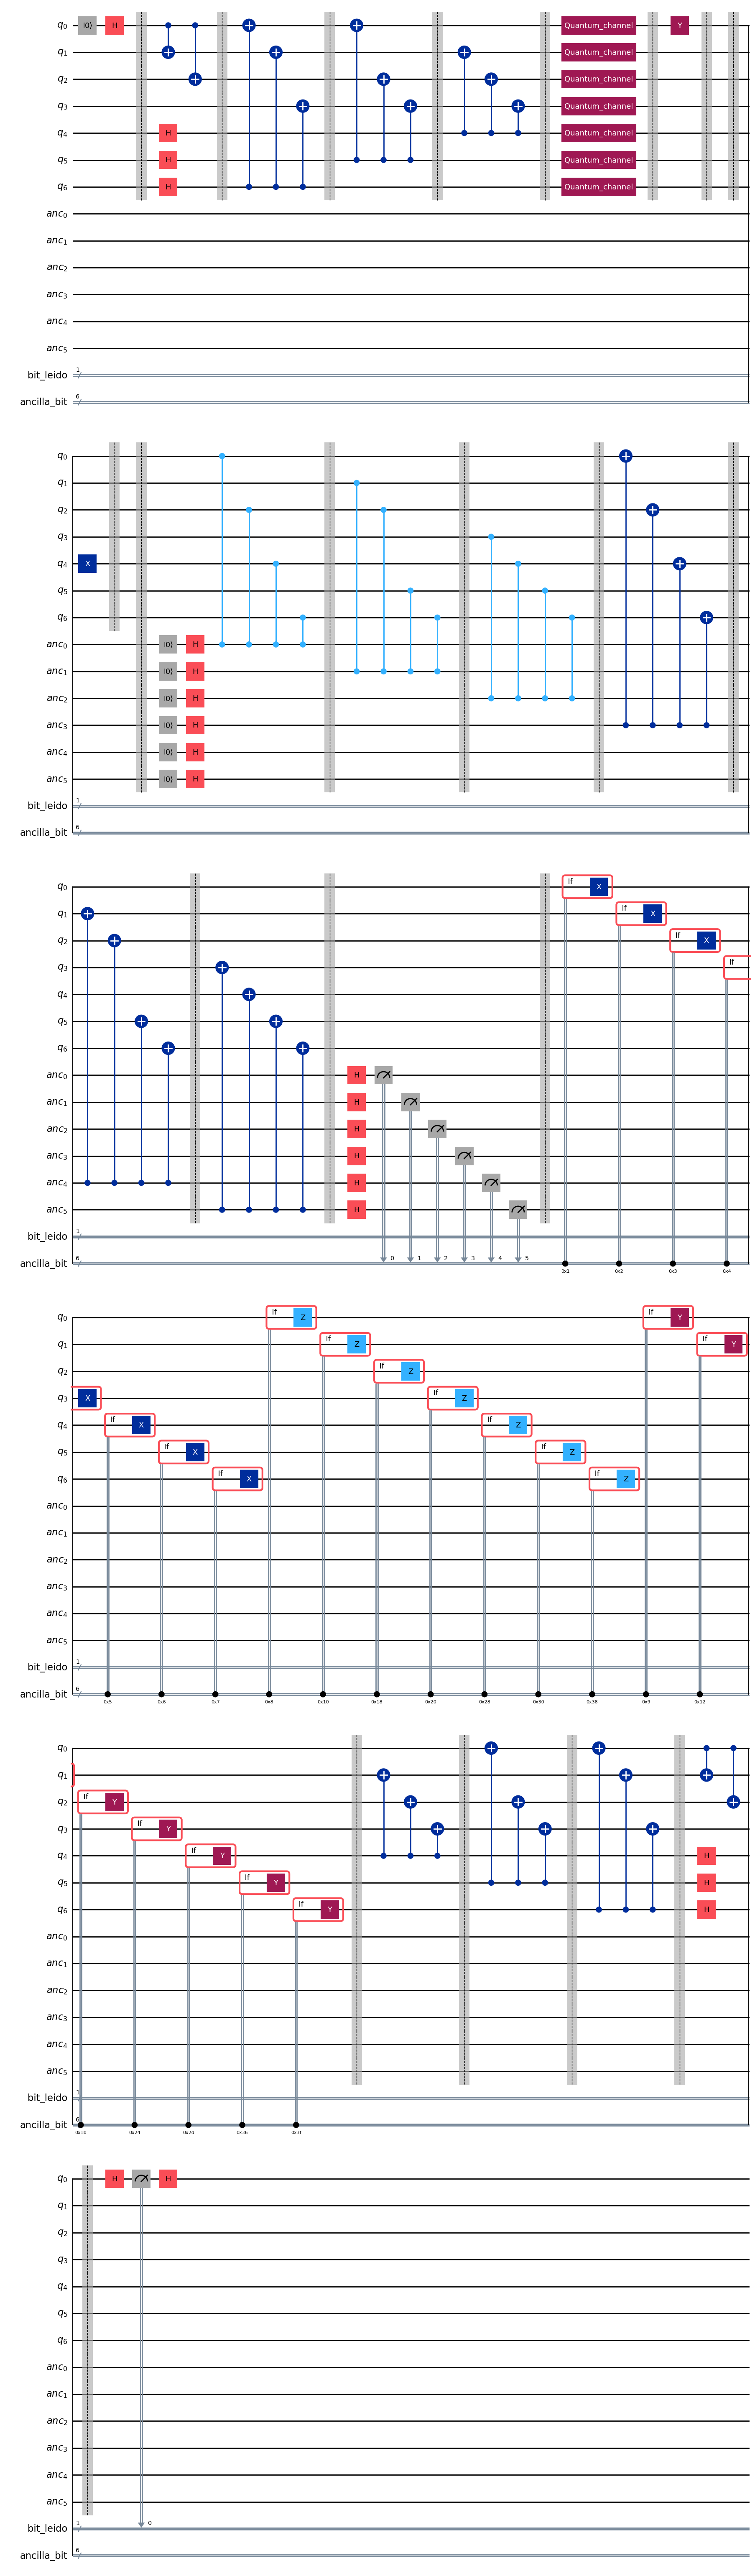

Qubit 1 | Bit: 1 | Base: (diagonal)


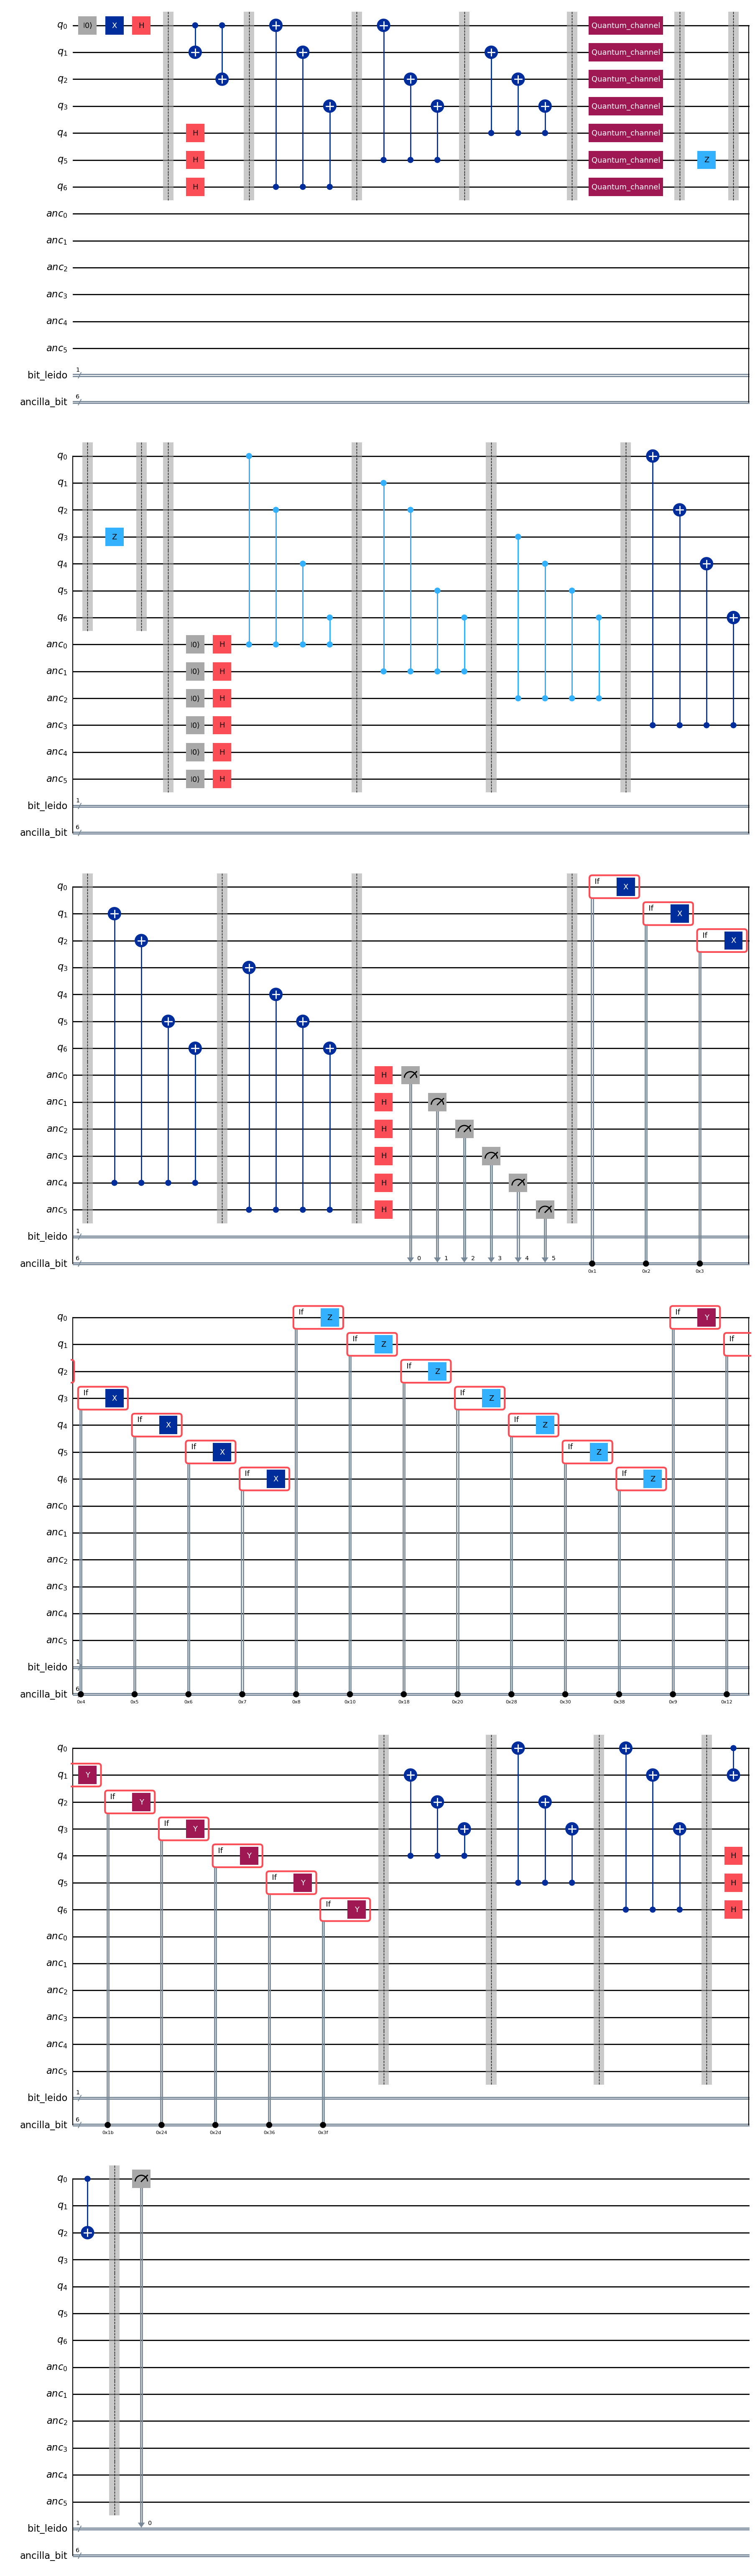

Qubit 2 | Bit: 0 | Base: (computacional)


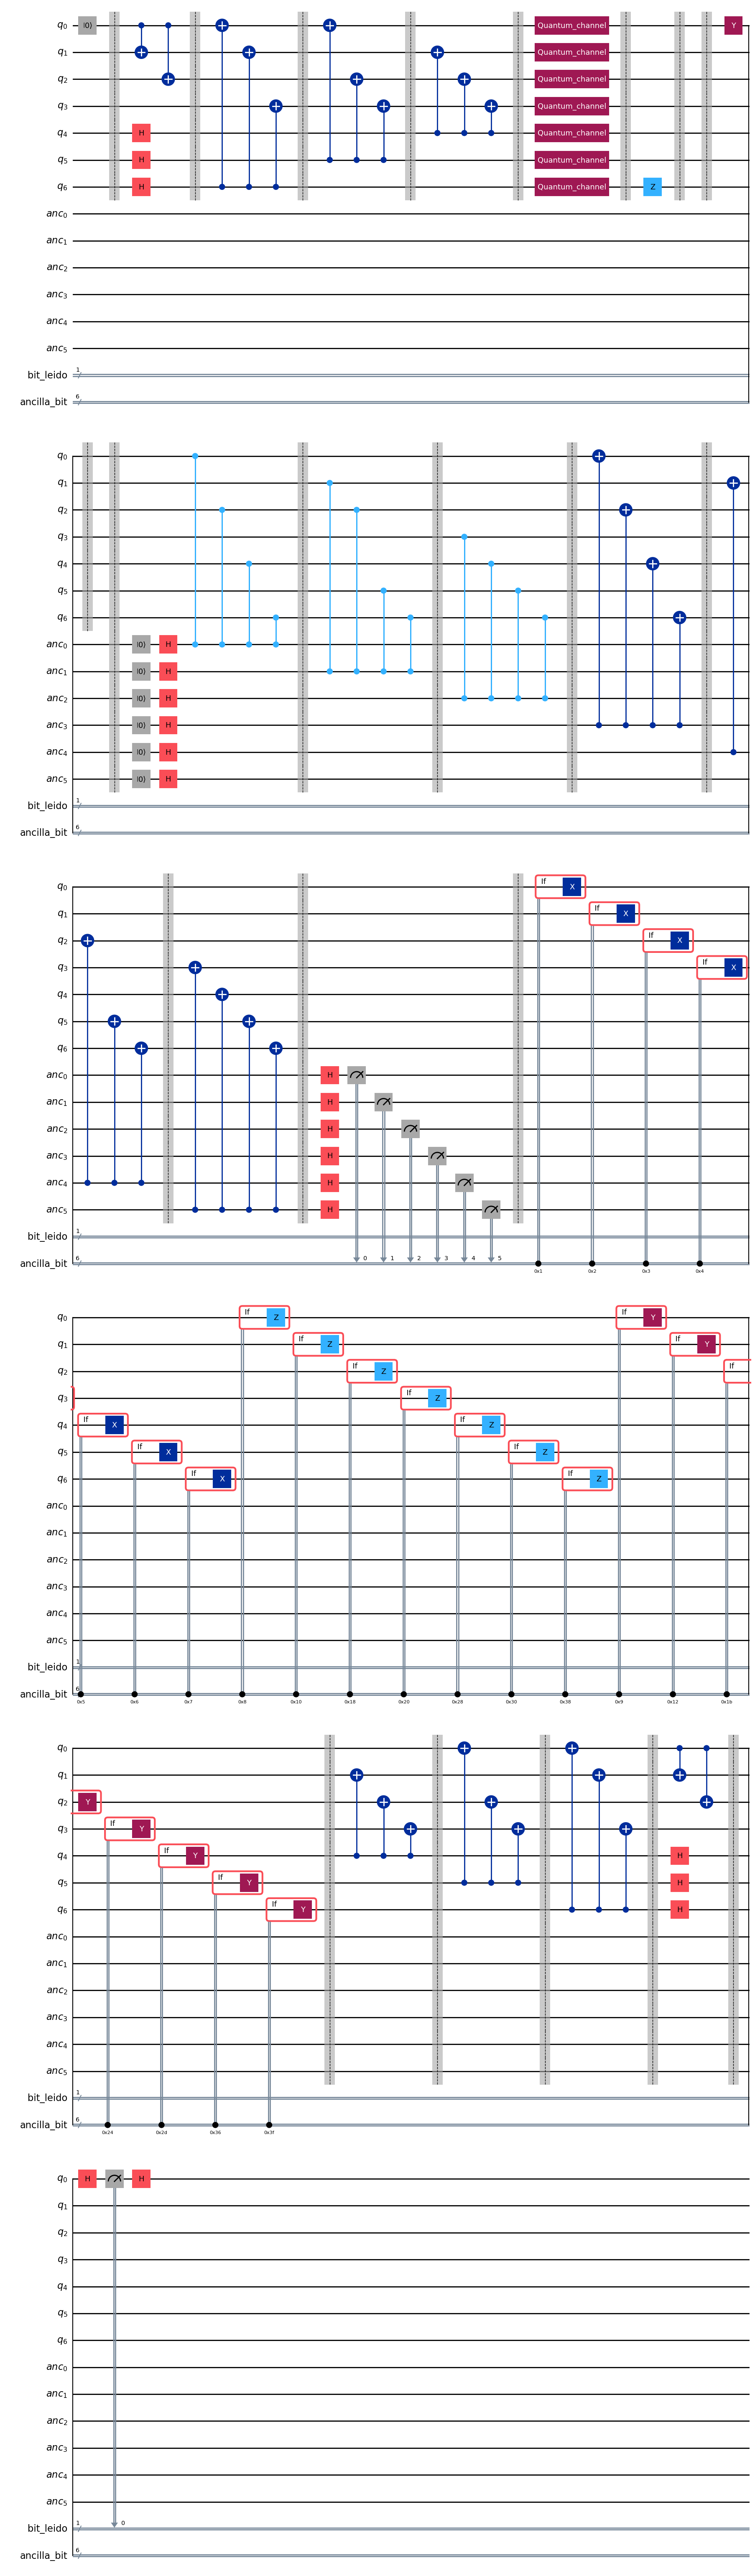

In [22]:
visualizar_secuencia(transmision, Alice_bits, Alice_bases, k=3)